Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Translation with an RNN

This notebook is modified from [this one](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb) created by Sylvain Gugger.

Today we will be tackling the task of translation. We will be translating from French to English, and to keep our task a manageable size, we will limit ourselves to translating questions.

This task is an example of sequence to sequence (seq2seq). Seq2seq can be more challenging than classification, since the output is of variable length (and typically different from the length of the input.

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

Translation is much tougher in straight PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [14]:
from fastai.text import *

## Download and preprocess our data

We will start by reducing the original dataset to questions. You only need to execute this once, uncomment to run. The dataset can be downloaded [here](https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz).

In [15]:
path = Config().data_path()


In [16]:

# ! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

In [17]:
# ! tar xf {path}/giga-fren.tgz -C {path} 

In [18]:
path = Config().data_path()/'eng-fra-data'
path.ls()

[PosixPath('/home/jupyter/data/eng-fra-data/fr_emb.pth'),
 PosixPath('/home/jupyter/data/eng-fra-data/data_save.pkl'),
 PosixPath('/home/jupyter/data/eng-fra-data/eng-fra.txt'),
 PosixPath('/home/jupyter/data/eng-fra-data/models'),
 PosixPath('/home/jupyter/data/eng-fra-data/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/data/eng-fra-data/en_emb.pth'),
 PosixPath('/home/jupyter/data/eng-fra-data/names')]

In [19]:
#with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')[:100]

In [20]:
#with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')[:100]

We will use regex to pick out questions by finding the strings in the English dataset that start with "Wh" and end with a question mark.  You only need to run these lines once:

In [21]:
#re_eq = re.compile('^(Wh[^?.!]+\?)')
#re_fq = re.compile('^([^?.!]+\?)')
#en_fname = path/'giga-fren.release2.fixed.en'
#fr_fname = path/'giga-fren.release2.fixed.fr'

In [22]:
#lines = ((re_eq.search(eq), re_fq.search(fq)) 
#    for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
#qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [23]:
#qs = [(q1,q2) for q1,q2 in qs]
#df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
#df.to_csv(path/'questions_easy.csv', index=False)

## Load our data into a DataBunch

Our questions look like this now:

In [24]:
#df = pd.read_csv(path/'questions_easy.csv')
import pandas as pd
df = pd.read_csv('~/data/eng-fra-data/eng-fra.txt', sep='\t', header=None)
df['en']=df[0]
df['fr']=df[1]
df.head()

,0,1,en,fr
0,Go.,Va !,Go.,Va !
1,Run!,Cours !,Run!,Cours !
2,Run!,Courez !,Run!,Courez !
3,Wow!,Ça alors !,Wow!,Ça alors !
4,Fire!,Au feu !,Fire!,Au feu !


To make it simple, we lowercase everything.

In [25]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

The first thing is that we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same;

In [26]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

Then we create a special `DataBunch` that uses this collate function.

In [27]:
doc(Dataset)

class Dataset [test] Dataset () 
 
 × No tests found for Dataset . To contribute a test please refer to this guide and this discussion . An abstract class representing a :class: Dataset . All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overrite :meth: __getitem__ , supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth: __len__ , which is expected to return the size of the dataset by many
:class: ~torch.utils.data.Sampler implementations and the default options
of :class: ~torch.utils.data.DataLoader . 
 .. note::
 :class: ~torch.utils.data.DataLoader by default constructs a index
 sampler that yields integral indices. To make it work with a map-style
 dataset with non-integral indices/keys, a custom sampler must be provided.

In [28]:
doc(DataLoader)

class DataLoader [test] DataLoader ( dataset , batch_size = 1 , shuffle = False , sampler = None , batch_sampler = None , num_workers = 0 , collate_fn = 'default_collate' , pin_memory = True , drop_last = False , timeout = 0 , worker_init_fn = None ) 
 
 × No tests found for DataLoader . To contribute a test please refer to this guide and this discussion . Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. 
 The :class: ~torch.utils.data.DataLoader supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning. 
 See :py:mod: torch.utils.data documentation page for more details. 
 Arguments:
 dataset (Dataset): dataset from which to load the data.
 batch_size (int, optional): how many samples per batch to load
 (default: 1 ).
 shuffle (bool, optional): set to True to have the data reshuffled
 at every epoch (default: False ).
 sampler (Sampler, optional): defines the strategy to draw samples from
 the dataset. If specified, :attr: shuffle must be False .
 batch_sampler (Sampler, optional): like :attr: sampler , but returns a batch of
 indices at a time. Mutually exclusive with :attr: batch_size ,
 :attr: shuffle , :attr: sampler , and :attr: drop_last .
 num_workers (int, optional): how many subprocesses to use for data
 loading. 0 means that the data will be loaded in the main process.
 (default: 0 )
 collate_fn (callable, optional): merges a list of samples to form a
 mini-batch of Tensor(s). Used when using batched loading from a
 map-style dataset.
 pin_memory (bool, optional): If True , the data loader will copy Tensors
 into CUDA pinned memory before returning them. If your data elements
 are a custom type, or your :attr: collate_fn returns a batch that is a custom type,
 see the example below.
 drop_last (bool, optional): set to True to drop the last incomplete batch,
 if the dataset size is not divisible by the batch size. If False and
 the size of dataset is not divisible by the batch size, then the last batch
 will be smaller. (default: False )
 timeout (numeric, optional): if positive, the timeout value for collecting a batch
 from workers. Should always be non-negative. (default: 0 )
 worker_init_fn (callable, optional): If not None , this will be called on each
 worker subprocess with the worker id (an int in [0, num_workers - 1] ) as
 input, after seeding and before data loading. (default: None ) 
 .. warning:: If the spawn start method is used, :attr: worker_init_fn 
 cannot be an unpicklable object, e.g., a lambda function. See
 :ref: multiprocessing-best-practices on more details related
 to multiprocessing in PyTorch. 
 .. note:: len(dataloader) heuristic is based on the length of the sampler used.
 When :attr: dataset is an :class: ~torch.utils.data.IterableDataset ,
 an infinite sampler is used, whose :meth: __len__ is not
 implemented, because the actual length depends on both the
 iterable as well as multi-process loading configurations. So one
 should not query this method unless they work with a map-style
 dataset. See Dataset Types _ for more details on these two types
 of datasets.

In [29]:
doc(DataBunch)

class DataBunch [source] [test] DataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) 
 
 × Tests found for DataBunch : pytest -sv tests/test_data_block.py::test_custom_dataset [source] To run tests please refer to this guide . Bind train_dl , valid_dl and test_dl in a data object. 
 Show in docs

In [30]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [31]:
SortishSampler??

Init signature:
SortishSampler(
    data_source: Collection[numpy.ndarray],
    key: Callable[[int], int],
    bs: int,
)
Source:        
class SortishSampler(Sampler):
    "Go through the text data by order of length with a bit of randomness."

    def __init__(self, data_source:NPArrayList, key:KeyFunc, bs:int):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = np.random.permutation(len(self.data_source))
        sz = self.bs*50
        ck_idx = [idxs[i:i+sz] for i in range(0, len(idxs), sz)]
        sort_idx = np.concatenate([sorted(s, key=self.key, reverse=True) for s in ck_idx])
        sz = self.bs
        ck_idx = [sort_idx[i:i+sz] for i in range(0, len(sort_idx), sz)]
        max_ck = np.argmax([self.key(ck[0]) for ck in ck_idx])  # find the chunk with the largest key,
        ck_idx[0],ck_idx[max_ck] = ck_idx[max_ck],ck_idx[0]     # then make sure it goes first.
   

And a subclass of `TextList` that will use this `DataBunch` class in the call `.databunch` and will use `TextList` to label (since our targets are other texts).

In [32]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!

In [33]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

In [34]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

13.0

In [35]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

12.0

We remove the items where one of the target is more than 30 tokens long.

In [36]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [37]:
len(src.train) + len(src.valid)

135791

In [38]:
data = src.databunch()

In [39]:
data.save()

In [40]:
data

Seq2SeqDataBunch;

Train: LabelList (108632 items)
x: Seq2SeqTextList
xxbos cours   !,xxbos courez   !,xxbos ça alors   !,xxbos à l'aide   !,xxbos saute .
y: TextList
xxbos run !,xxbos run !,xxbos wow !,xxbos help !,xxbos jump .
Path: /home/jupyter/data/eng-fra-data;

Valid: LabelList (27159 items)
x: Seq2SeqTextList
xxbos le vent était tellement fort que nous avons presque été xxunk en dehors de la route .,xxbos tu ne peux jamais être heureux si tu te sens envieux à l'égard xxunk .,xxbos xxunk le problème !,xxbos cessez , je vous prie !,xxbos vous êtes celui - là .
y: TextList
xxbos the wind was so strong , we were nearly blown off the road .,xxbos you can never be happy if you feel envious of other people .,xxbos let 's reconsider the problem .,xxbos stop it , please .,xxbos you are the one .
Path: /home/jupyter/data/eng-fra-data;

Test: None

In [41]:
path

PosixPath('/home/jupyter/data/eng-fra-data')

In [42]:
data = load_data(path)

In [43]:
data.show_batch()

text,target
"xxbos conformément au contrat , vous pouvez prendre trois jours de congé de décès pour les funérailles de votre oncle , mais un seul pour celles de votre neveu .","xxbos according to the contract you may take three days of bereavement leave for your uncle 's funeral , but only one for your nephew 's ."
"xxbos de toutes les choses que tom a faites le week - end dernier , il dit que la planche à voile était la plus amusante .","xxbos of all the things tom did last weekend , he says that xxunk was the most fun ."
xxbos je ne vois jamais une bibliothèque sans souhaiter avoir le temps de m'y rendre et d'y rester jusqu'à ce que j'y aie tout lu .,xxbos i never see a library without xxunk i had time to go there and stay till i had read everything in it .
"xxbos nous irons au cinéma , la prochaine fois . "" qu'est - ce qui vous fait penser qu'il y aura une prochaine fois ? ""","xxbos let 's go to the movies next time . "" what makes you think there will be a next time ? """
xxbos il y a deux sortes de travail dans le monde : celui de la tête et celui des mains ; xxunk et manuel .,xxbos there are two kinds of work in the world xxunk head work and hand work ; mental and manual .


## Create our Model

### Pretrained embeddings

You will need to download the word embeddings (crawl vectors) from the fastText docs. FastText has [pre-trained word vectors](https://fasttext.cc/docs/en/crawl-vectors.html) for 157 languages, trained on Common Crawl and Wikipedia. These models were trained using CBOW.

If you need a refresher on word embeddings, you can check out my gentle intro in [this word embedding workshop](https://www.youtube.com/watch?v=25nC0n9ERq4&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=10&t=0s) with accompanying [github repo](https://github.com/fastai/word-embeddings-workshop). 

More reading on CBOW (Continuous Bag of Words vs. Skip-grams):

- [fastText tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html#advanced-readers-skipgram-versus-cbow)
- [StackOverflow](https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words)

To install fastText:
```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```

In [44]:
!pip install fasttext
import fasttext as ft

The lines to download the word vectors only need to be run once:

In [45]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

In [46]:
# gunzip {path} / cc.en.300.bin.gz
# gunzip {path} / cc.fr.300.bin.gz

In [47]:
fr_vecs = ft.load_model(str(('/home/jupyter/data/cc.fr.300.bin')))
en_vecs = ft.load_model(str(('/home/jupyter/data/cc.en.300.bin')))

We create an embedding module with the pretrained vectors and random data for the missing parts.

In [48]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [49]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [50]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([10464, 300]), torch.Size([6512, 300]))

In [51]:
model_path = Config().model_path()

In [52]:
torch.save(emb_enc, path/'fr_emb.pth')
torch.save(emb_dec, path/'en_emb.pth')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [53]:
emb_enc = torch.load(path/'fr_emb.pth')
emb_dec = torch.load(path/'en_emb.pth')

## Our Model

Review Question: What are the two types of numbers in deep learning?

### Encoders & Decoders

The model in itself consists in an encoder and a decoder

![Seq2seq model](images/seq2seq.png)

<center><i>Diagram from Smerity's <a href="https://smerity.com/articles/2016/google_nmt_arch.html">Peeking into the neural network architecture used for Google's Neural Machine Translation</a></i></center>

The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state.  A **hidden state** is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training). 

We will use a GRU for our encoder and a separate GRU for our decoder. Other options are to use LSTMs or QRNNs (see here).  GRUs, LSTMs, and QRNNs all solve the problem of how RNNs can lack long-term memory.

Links:
- [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [fast.ai implementation of seq2seq with QRNNs](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb)

In [54]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [55]:
xb,yb = next(iter(data.valid_dl))

In [56]:
xb.shape

torch.Size([64, 30])

In [57]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [58]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(10464, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(6512, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=6512, bias=True)
)

In [59]:
len(xb[0])

30

In [60]:
h = rnn.encoder(64, xb.cpu())

In [61]:
h.size()

torch.Size([2, 64, 300])

The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [62]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our model

In [63]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


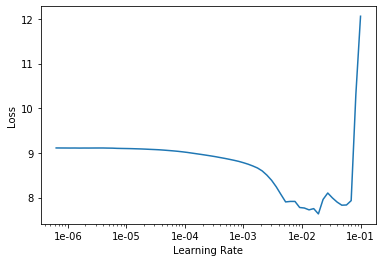

In [65]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,3.063637,2.667045,01:16
1,2.657815,2.025264,01:20
2,2.530175,2.453182,01:11
3,2.473664,2.460207,01:22


Let's free up some RAM

In [67]:
del fr_vecs
del en_vecs

As loss is not very interpretable, let's also look at the accuracy.  Again, we will add padding so that the output and target are of the same length.

In [68]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Bleu metric (see dedicated notebook)

In translation, the metric usually used is BLEU.

A great post by Rachael Tatman: [Evaluating Text Output in NLP: BLEU at your own risk](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

In [69]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [70]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [71]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [72]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training with metrics

In [73]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


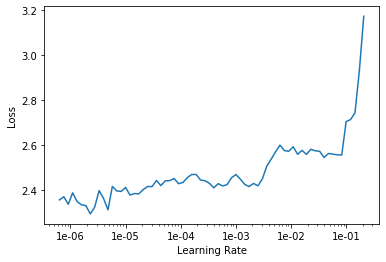

In [75]:
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.767991,3.120510,0.489786,0.300205,02:01
1,2.889867,3.076199,0.496212,0.305587,02:05
2,2.616363,3.182902,0.471185,0.308751,02:03
3,2.536122,2.772401,0.518600,0.336282,01:14


In [77]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.606913,2.558938,0.544116,0.342630,01:11
1,2.381359,2.756686,0.518783,0.334313,01:11
2,2.368385,2.603505,0.538325,0.345629,01:11
3,2.338424,2.584584,0.540696,0.348304,01:11


So how good is our model? Let's see a few predictions.

In [78]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [79]:
inputs, targets, outputs = get_predictions(learn)

In [80]:
inputs[700], targets[700], outputs[700]

(Text xxbos quels sont les aliments qu'on mange habituellement avec de la sauce de soja   ?,
 Text xxbos what are some foods you usually eat with soy sauce ?,
 Text xxbos what are are foods foods eat eat ? ?)

In [81]:
inputs[701], targets[701], outputs[701]

(Text xxbos je ne pense pas que ça me dérangerait de manger chinois tous les jours .,
 Text xxbos i do n't think i 'd mind eating chinese food every day .,
 Text xxbos i do n't think eat eat eat eat eat)

In [82]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos j'ai écouté mais je n'ai pas pu distinguer ce qu'ils xxunk .,
 Text xxbos i listened but could n't make out what they were saying .,
 Text xxbos i could could could could could could could but could could could could)

In [83]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos il y a beaucoup de tremblements de terre au japon .,
 Text xxbos we have a lot of earthquakes in japan .,
 Text xxbos there is many lot lot of . .)

It's usually beginning well, but falls into repeated words at the end of the question.

## Teacher forcing

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [84]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

We will add the following code to our `forward` method:

```
    if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
```
Additionally, `forward` will take an additional argument of `target`.

In [85]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [86]:
emb_enc = torch.load(path/'fr_emb.pth')
emb_dec = torch.load(path/'en_emb.pth')


In [87]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

In [88]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


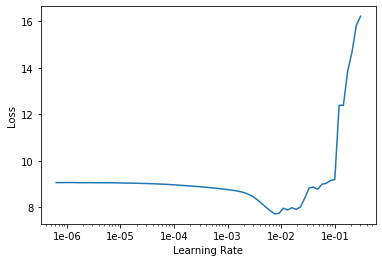

In [89]:
learn.recorder.plot()

In [90]:
learn.fit_one_cycle(6, 3e-3)
learn.export('/home/jupyter/data/translation_fastai_seq2seq_export.pkl')
learn.save('/home/jupyter/data/translation_fastai_seq2seq_learn')

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.702562,3.286544,0.571327,0.309566,01:24
1,1.528624,2.187998,0.623373,0.450276,01:16
2,1.677970,1.979097,0.638976,0.506280,01:13
3,1.642650,1.575299,0.689907,0.524269,01:12
4,1.382120,1.480329,0.710863,0.555965,01:16
5,1.197429,1.439226,0.718752,0.567122,01:18


In [91]:
inputs, targets, outputs = get_predictions(learn)

In [92]:
inputs[700],targets[700],outputs[700]

(Text xxbos quels sont les aliments qu'on mange habituellement avec de la sauce de soja   ?,
 Text xxbos what are some foods you usually eat with soy sauce ?,
 Text xxbos what are some foods you usually usually with with with ?)

In [93]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos j'ai écouté mais je n'ai pas pu distinguer ce qu'ils xxunk .,
 Text xxbos i listened but could n't make out what they were saying .,
 Text xxbos i listened to . , i could n't n't n't help them .)

In [94]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos il y a beaucoup de tremblements de terre au japon .,
 Text xxbos we have a lot of earthquakes in japan .,
 Text xxbos there are many lot of japan in japan)

In [116]:
#learn = load_learner('/home/jupyter/data/', 'translation_fastai_seq2seq_export.pkl')
#@doc(Learner)
learn.load('/home/jupyter/data/translation_fastai_seq2seq_learn')
#pred = learn.predict(learn.data.train_ds)

##print(df['fr'].iloc[66])
#print(inputs[1], t)
#inputs[4000], targets[4000], outputs[4000]


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/anac

Learner(data=Seq2SeqDataBunch;

Train: LabelList (0 items)
x: Seq2SeqTextList

y: TextList

Path: /home/jupyter/data;

Valid: LabelList (0 items)
x: Seq2SeqTextList

y: TextList

Path: /home/jupyter/data;

Test: None, model=Seq2SeqRNN_tf(
  (emb_enc): Embedding(10464, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(6512, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=6512, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function seq2seq_loss at 0x7f8f48e3ee60>, metrics=[<function seq2seq_acc at 0x7f8f47552830>, CorpusBLEU
vocab_sz: 6512], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('/home/jupyte